In [1064]:
%load_ext autoreload

%autoreload 2
import pickle
import sys
import emcee
import CL_fiducial_mass_richness_relation as cl
from astropy.table import Table, join
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules/')
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_fit_cluster_mass as fit
import mcmc
import CL_Likelihood_for_Mass_richness_relation as mr
import analysis_Mass_Richness_relation as analysis
import CL_fiducial_mass_richness_relation as fiducial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1065]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [1066]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

dat_RM = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/RedMapper_galaxy_clusters.pkl')
dat_cosmodc2 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/SkySim5000_DM_halos.pkl')
dat_cosmodc2['M200c'] = dat_cosmodc2['baseDC2/sod_halo_mass']/0.71
dat_cosmodc2 = dat_cosmodc2

In [1067]:
richness_catalog = Table({'obs':dat_RM['richness'], 'ra':dat_RM['ra'], 'dec':dat_RM['dec'],'redshift':dat_RM['redshift'], 'id':np.arange(len(dat_RM['redshift']))})

In [1068]:
mass_catalog = Table({'obs':dat_cosmodc2['M200c'], 'ra':dat_cosmodc2['ra'], 'dec':dat_cosmodc2['dec'],'redshift':dat_cosmodc2['redshift'],'id':np.arange(len(dat_cosmodc2['redshift']))})
mass_catalog = mass_catalog[mass_catalog['redshift']<1.2]
mass_catalog = mass_catalog[mass_catalog['redshift']>.2]
mass_catalog = mass_catalog[mass_catalog['obs']>3e13]

In [1069]:
match_table_my=cl.match_catalog(mass_catalog, richness_catalog, clevar=False)

In [1070]:
#match_table_clevar=cl.match_catalog(mass_catalog, richness_catalog, clevar=True)

In [1071]:
#binned_clevar=cl.make_binned(match_table_clevar['mass_1'], match_table_clevar['mass_2'], match_table_clevar['z_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

In [1072]:
binned_my=cl.make_binned(match_table_my['obs_1'], match_table_my['obs_2'], match_table_my['redshift_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

In [1073]:
n_per_bin=np.array([len(z) for z in binned_my['redshift_in_bin']])

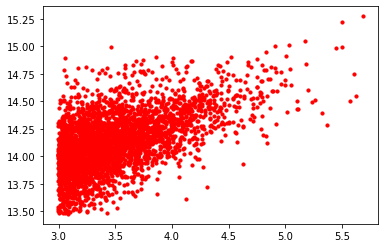

In [1074]:
#plt.scatter(match_table_clevar['mass_2'],match_table_clevar['mass_1'],c='g')
plt.scatter(np.log(match_table_my['obs_2']),np.log10(match_table_my['obs_1']),c='r', s=10)
#plt.loglog()

In [1075]:
binned_my.keys()

dict_keys(['Z_bin', 'Obs_bin', 'z_mean', 'logrichness', 'richness_err', 'm200', 'm200_err', 'n_stack', 'logrichness_in_bin', 'redshift_in_bin', 'M200c_in_bin', 'logrichness_err_in_bin', 'redshift_err_in_bin'])

In [1076]:
logm=np.log10(np.array(binned_my['m200']))
logm_err=np.array(binned_my['m200_err'])/(np.log(10)*np.array(binned_my['m200']))
richness_individual = 10**np.array(binned_my['logrichness_in_bin'])
richness = np.array([np.mean(richness_individual[i]) for i in range(len(richness_individual))])
richness_err = np.array([np.std(richness_individual[i]) for i in range(len(richness_individual))])
z_individual = binned_my['redshift_in_bin']
z = np.array([np.mean(z_individual[i]) for i in range(len(z_individual))])
z_err = 0
weight_individual = None
Gamma=.7

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [1077]:
WL_Mlambda = mr.WL_Mass_Richness(logm=logm, logm_err=logm_err, 
                                richness=richness, richness_err=richness_err, 
                                z=z, z_err=z_err,
                                richness_individual=np.array(richness_individual), z_individual=np.array(z_individual),
                                n_cluster_per_bin=None,
                                weights_individual=z_individual)
WL_Mlambda.set_pivot_values(analysis.z0, analysis.richness0)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [1078]:
def lnL_WL(theta, likelihood, Gamma):
    if likelihood=='classic': return WL_Mlambda.lnLikelihood_binned_classic(theta)
    if likelihood=='individual_zrichness': return WL_Mlambda.lnLikelihood_individual_zrichness(theta, Gamma)
    if likelihood=='intrinsic_scatter': return WL_Mlambda.lnLikelihood_binned_intrinsic_scatter(theta)

In [1079]:
sampler = mcmc.constraint_mcmc(lnL_WL, ('classic', .7), theta0=[14,0,1,], npath=300, nwalkers=200)

100%|██████████| 300/300 [00:03<00:00, 94.06it/s]


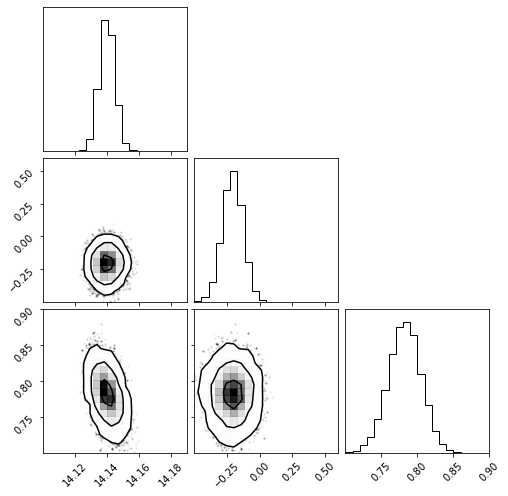

In [1081]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)

sample_cut = sampler[15000:]
fig = corner.corner(
sample_cut[sample_cut[:,0]>0],
bins=20, levels=(sigma1, sigma2,sigma3),color='k',range=[(14.1,14.19), (-0.5, 0.6), (0.7, 0.9),])#(0,.4)])

In [1061]:
np.mean(sample_cut[sample_cut[:,3]>0],axis=0)

IndexError: index 3 is out of bounds for axis 1 with size 3

# purity and completness

In [809]:
logm = np.linspace(np.log10(3e13), 15, 10)
richness=np.linspace(20, 100, 10)
z=np.linspace(.2, 1., 10)

In [810]:
binned_true_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(mass_catalog['obs']), mass_catalog['redshift'], bins=[logm, z])

In [811]:
binned_matched_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(match_table_my['obs_1']), match_table_my['redshift_1'], bins=[logm, z])

In [812]:
binned_true_richness_cat, axis1_richness, axis2_z =np.histogram2d(richness_catalog['obs'], richness_catalog['redshift'], bins=[richness, z])

In [813]:
binned_matched_richness_cat, axis1_richness, axis2_z =np.histogram2d(match_table_my['obs_2'], match_table_my['redshift_2'], bins=[richness, z])

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


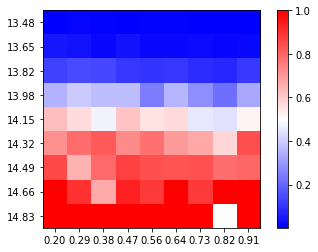

In [814]:
completness = binned_matched_mass_cat/binned_true_mass_cat
plt.imshow(completness, cmap='bwr')
plt.yticks(ticks=np.arange(len(axis1_mass)-1), labels=[f'{s:.2f}' for s in axis1_mass]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.colorbar()

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


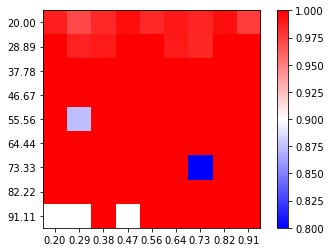

In [815]:
purity = binned_matched_richness_cat/binned_true_richness_cat
plt.yticks(ticks=np.arange(len(axis1_richness)-1), labels=[f'{s:.2f}' for s in axis1_richness]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.imshow(purity, cmap='bwr')
plt.colorbar()

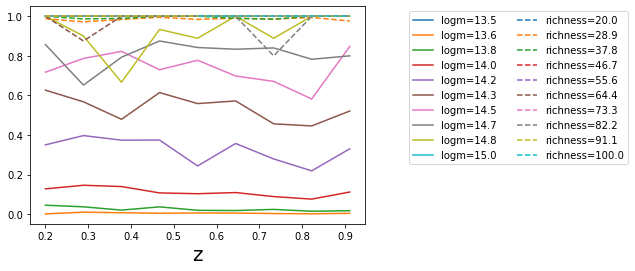

In [803]:
for i, m in enumerate(logm):
    plt.plot(axis2_z[:-1], completness[i-1,:], label=f'logm={m:.1f}')
for i, rich in enumerate(richness):
    plt.plot(axis2_z[:-1], purity[i-1,:], '--', label=f'richness={rich:.1f}')
plt.xlabel('z', fontsize=20)
plt.legend(ncol=2,bbox_to_anchor=(0,0,1.8,1), )